<a href="https://colab.research.google.com/github/79AceVo/Text-analytics/blob/main/Text_Classification_GRU_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRU for Text Classification

This notebook covers:
1. **GRU Binary** — Gated Recurrent Unit for economic news relevance
2. **GRU Multi-class** — Topic categorization
3. **GRU Multi-label** — Multi-topic tagging
4. **GRU vs LSTM Comparison** — Speed, accuracy, parameters
5. **Hyperparameter Tuning** — Full experiment grid

---
### What is GRU?
GRU (Gated Recurrent Unit) is a **simplified LSTM** with only **2 gates** instead of 3:
- **Reset gate** — decides how much of the past to forget
- **Update gate** — decides how much of the new info to keep

| Feature | LSTM | GRU |
|---|---|---|
| Gates | 3 (forget, input, output) | 2 (reset, update) |
| Parameters | More (~33% more than GRU) | Fewer |
| Training speed | Slower | Faster |
| Performance | Slightly better on long sequences | Comparable on most tasks |
| Memory cell | Separate cell state + hidden state | Only hidden state |

**Rule of thumb**: Try GRU first (faster). If accuracy isn't good enough, switch to LSTM.

#Enable GPU prior to run

In Colab, change Runtime to T4 for faster processing.

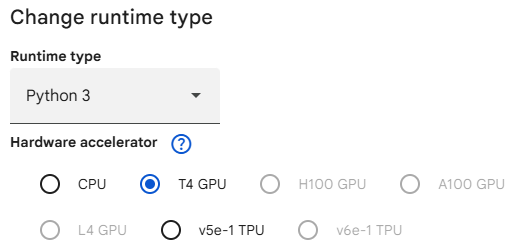

Normal runtime will takes much longer


## Part 0: Setup & Data Preparation

In [36]:
# ============================================================
# IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)

import string, re, warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [39]:
# ============================================================
# ⚡ CONFIGURATION — Adjust these for speed vs accuracy
# ============================================================
MAX_LEN = 500         # max sequence length (tokens)
VOCAB_SIZE = 5000     # vocabulary size
EMBED_DIM = 32        # embedding dimensions (smaller = faster)
BATCH_SIZE = 128      # batch size (larger = faster on GPU)
EPOCHS = 5            # max epochs
PATIENCE = 3          # early stopping patience

print(f"Config: MAX_LEN={MAX_LEN}, VOCAB={VOCAB_SIZE}, EMBED={EMBED_DIM}")
print(f"        BATCH={BATCH_SIZE}, EPOCHS={EPOCHS}, PATIENCE={PATIENCE}")

Config: MAX_LEN=500, VOCAB=5000, EMBED=32
        BATCH=128, EPOCHS=5, PATIENCE=3


In [11]:
# ============================================================
# DATA PATH — Works on both Colab and local
# ============================================================
import os, subprocess

# GitHub repo URL for raw data files
REPO = "https://raw.githubusercontent.com/79AceVo/Text-analytics/main/Data"

def get_data(filename, sep=',', encoding=None):
    """Load CSV from local Data/ folder or download from GitHub."""
    local_paths = [
        f"Data/{filename}",             # local: Data/ subfolder
        filename,                        # local: same directory
        f"/content/Data/{filename}",     # Colab: mounted drive
        f"/content/{filename}",          # Colab: uploaded file
    ]

    # Try local paths first
    for path in local_paths:
        if os.path.exists(path):
            print(f"✅ Found locally: {path}")
            return pd.read_csv(path, sep=sep, low_memory=False, encoding=encoding)

    # Download from GitHub
    url = f"{REPO}/{filename}"
    print(f"⬇️  Downloading from GitHub: {filename}...")
    try:
        df = pd.read_csv(url, sep=sep, low_memory=False, encoding=encoding)
        print(f"✅ Downloaded ({len(df)} rows)") # Fixed: Removed unescaped newline
        return df
    except Exception as e:
        print(f"❌ Download failed: {e}")
        print(f"   Please place {filename} in a Data/ folder or upload it.")
        raise

print("✅ get_data() ready — checks local paths first, downloads from GitHub if needed")

✅ get_data() ready — checks local paths first, downloads from GitHub if needed


In [12]:
# LOAD DATA
df = get_data("econ_news.csv", encoding="ISO-8859-1")
print(f"Shape: {df.shape}")
df.head(3)

⬇️  Downloading from GitHub: econ_news.csv...
✅ Downloaded (8000 rows)
Shape: (8000, 15)


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.64,yes,0.64,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.00,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.00,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...


In [13]:
# ============================================================
# DATA PREPROCESSING
# ============================================================
# Remove ambiguous labels
df = df[df["relevance"] != "not sure"]

# Binary encode: yes=1, no=0
df["relevance"] = df["relevance"].map({'yes': 1, 'no': 0})

# Keep only what we need
data = df[["text", "relevance"]].copy()
print(f"Clean dataset shape: {data.shape}")
print(f"Class balance: {data['relevance'].value_counts().to_dict()}")

Clean dataset shape: (7991, 2)
Class balance: {0: 6571, 1: 1420}


In [14]:
# ============================================================
# TEXT CLEANING FUNCTION
# ============================================================
stop_words = set(stopwords.words('english'))

def clean(doc):
    """Remove HTML, punctuation, digits, stopwords"""
    doc = doc.replace("</br>", " ")
    tokens = doc.split()
    tokens = [t for t in tokens
              if t not in string.punctuation
              and not t.isdigit()
              and t not in stop_words]
    return " ".join(tokens)

data["text"] = data["text"].apply(clean)
print("Sample cleaned text:")
print(data["text"].iloc[0][:200], "...")

Sample cleaned text:
NEW YORK -- Yields certificates deposit offered major banks dropped tenth percentage point latest week, reflecting overall decline short-term interest rates. On small-denomination, "consumer," CDs sol ...


In [15]:
# ============================================================
# TRAIN-TEST SPLIT & VECTORIZATION
# ============================================================
X = data["text"]
y = data["relevance"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"Train: {X_train.shape[0]} samples | Test: {X_test.shape[0]} samples")
print(f"Train class balance: {y_train.value_counts().to_dict()}")

# Vectorize with CountVectorizer
vect = CountVectorizer(preprocessor=clean, max_features=10000)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
print(f"Vocabulary size: {len(vect.vocabulary_)}")

# Pad sequences for neural network input
MAX_LEN = 5000
X_train_dense = pad_sequences(X_train_dtm.toarray(), maxlen=MAX_LEN, padding='post', truncating='post')
X_test_dense = pad_sequences(X_test_dtm.toarray(), maxlen=MAX_LEN, padding='post', truncating='post')
print(f"Padded input shape: {X_train_dense.shape}")

Train: 5993 samples | Test: 1998 samples
Train class balance: {0: 4928, 1: 1065}
Vocabulary size: 10000
Padded input shape: (5993, 5000)


In [16]:
# ============================================================
# HELPER FUNCTIONS — Plotting & Evaluation
# ============================================================
def plot_history(history, title="Training History"):
    """Plot training & validation loss and accuracy curves."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    ax1.plot(history.history['loss'], label='Train Loss', color='steelblue')
    ax1.plot(history.history['val_loss'], label='Val Loss', color='coral')
    ax1.set_title(f'{title} — Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy
    acc_key = 'accuracy' if 'accuracy' in history.history else 'binary_accuracy'
    val_acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_binary_accuracy'
    ax2.plot(history.history[acc_key], label='Train Accuracy', color='steelblue')
    ax2.plot(history.history[val_acc_key], label='Val Accuracy', color='coral')
    ax2.set_title(f'{title} — Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test, title="Model"):
    """Evaluate and print classification report + confusion matrix."""
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    print(f"\n{'='*50}")
    print(f"  {title} — Evaluation Results")
    print(f"{'='*50}")
    print(classification_report(y_test, y_pred, target_names=['Not Relevant', 'Relevant']))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Not Relevant', 'Relevant'])
    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(ax=ax, cmap='Blues')
    ax.set_title(f'{title} — Confusion Matrix')
    plt.tight_layout()
    plt.show()
    return y_pred

def evaluate_multiclass(model, X_test, y_test, class_names, title="Model"):
    """Evaluate multi-class model."""
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)

    print(f"\n{'='*50}")
    print(f"  {title} — Evaluation Results")
    print(f"{'='*50}")
    print(classification_report(y_test, y_pred, target_names=class_names))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax, cmap='Blues')
    ax.set_title(f'{title} — Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    return y_pred

def evaluate_multilabel(model, X_test, y_test, label_names, threshold=0.5, title="Model"):
    """Evaluate multi-label model (sigmoid output)."""
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = (y_pred_prob > threshold).astype(int)

    print(f"\n{'='*50}")
    print(f"  {title} — Multi-Label Evaluation")
    print(f"{'='*50}")
    print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))

    # Per-label accuracy
    print("Per-label accuracy:")
    for i, name in enumerate(label_names):
        acc = accuracy_score(y_test[:, i], y_pred[:, i])
        print(f"  {name}: {acc:.3f}")
    return y_pred

In [17]:
# ============================================================
# EARLY STOPPING — The Smart Way to Choose Epochs
# ============================================================
# Instead of guessing epochs, let the model tell us when to stop.
# patience=5 means: stop if val_loss hasn't improved in 3 epochs.
# restore_best_weights=True means: use the weights from the best epoch.

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
print("✅ EarlyStopping callback ready (patience=5, restore_best_weights=True)")

✅ EarlyStopping callback ready (patience=5, restore_best_weights=True)


In [41]:
# ============================================================
# HELPER FUNCTIONS
# ============================================================
AUTOTUNE = tf.data.AUTOTUNE
def make_dataset(X, y, batch_size=BATCH_SIZE, shuffle=True):
    """Create optimized tf.data pipeline with cache + prefetch."""
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(len(X), seed=42)
    ds = ds.batch(batch_size).cache().prefetch(AUTOTUNE)
    return ds

def evaluate_multiclass(model, X_test, y_test, class_names, title="Model"):
    """Evaluate multi-class classifier."""
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    print(f"\n{'='*50}\n  {title}\n{'='*50}")
    print(classification_report(y_test, y_pred, target_names=class_names))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax, cmap='Blues')
    plt.xticks(rotation=45, ha='right'); ax.set_title(title)
    plt.tight_layout(); plt.show()

def evaluate_multilabel(model, X_test, y_test, label_names, title="Model"):
    """Evaluate multi-label classifier."""
    y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int)
    print(f"\n{'='*50}\n  {title} — Multi-Label\n{'='*50}")
    print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))
    print("Per-label accuracy:")
    for i, name in enumerate(label_names):
        print(f"  {name}: {accuracy_score(y_test[:, i], y_pred[:, i]):.3f}")

print("✅ Helpers ready (make_dataset, plot_history, evaluate functions)")

✅ Helpers ready (make_dataset, plot_history, evaluate functions)


---
## Part 1: Binary Classification — GRU
Same task, same data — just swap `LSTM()` → `GRU()`.
This is one of the key advantages of Keras: architectures are interchangeable.

In [21]:
# ============================================================
# MODEL 1A: GRU — Binary Classification
# ============================================================
model_gru_binary = keras.Sequential([
    layers.Embedding(input_dim=X_train_dense.shape[1], output_dim=64),
    layers.GRU(64),                                         # GRU instead of LSTM
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
], name="GRU_Binary")

model_gru_binary.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [22]:
# ============================================================
# MODEL 1B: Bidirectional GRU — Binary Classification
# ============================================================
model_bigru_binary = keras.Sequential([
    layers.Embedding(input_dim=X_train_dense.shape[1], output_dim=64),
    layers.Bidirectional(layers.GRU(64)),                    # Bi-GRU
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
], name="BiGRU_Binary")

model_bigru_binary.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)


In [28]:
# ============================================================
# TRAIN BOTH GRU MODELS
# ============================================================
class_weights = {0: 1, 1: 2}

# Train GRU
import time
print("Training GRU...")
start = time.time()
es1 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)
train_start = time.time()
history_gru = model_gru_binary.fit(
    X_train_dense, y_train, epochs=5, batch_size=32,
    validation_data=(X_test_dense, y_test),
    class_weight=class_weights, callbacks=[es1], verbose=1
)
train_time = time.time() - train_start
print(f"\n⏱️ Training time: {train_time:.1f} seconds")
gru_time = time.time() - start



Training GRU...
Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - accuracy: 0.8257 - loss: 0.7175 - val_accuracy: 0.8223 - val_loss: 0.5231
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 27s 146ms/step - accuracy: 0.8199 - loss: 0.7308 - val_accuracy: 0.8223 - val_loss: 0.4950
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 152ms/step - accuracy: 0.8180 - loss: 0.7340 - val_accuracy: 0.8223 - val_loss: 0.5036
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 147ms/step - accuracy: 0.8208 - loss: 0.7255 - val_accuracy: 0.8223 - val_loss: 0.5110
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 149ms/step - accuracy: 0.8241 - loss: 0.7228 - val_accuracy: 0.8223 - val_loss: 0.5280

⏱️ Training time: 153.4 seconds


In [29]:
model_gru_binary.summary()


Model: "GRU_Binary"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 5000, 64)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,035,077 (3.95 MB)

 Trainable params: 345,025 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 690,052 (2.63 MB)

In [30]:
# Train Bi-GRU
print("\nTraining Bi-GRU...")
start = time.time()
es2 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)
train_start = time.time()
history_bigru = model_bigru_binary.fit(
    X_train_dense, y_train, epochs=5, batch_size=32,
    validation_data=(X_test_dense, y_test),
    class_weight=class_weights, callbacks=[es2], verbose=1
)
train_time = time.time() - train_start
print(f"\n⏱️ Training time: {train_time:.1f} seconds")
bigru_time = time.time() - start

print(f"\n⏱️ GRU training time: {gru_time:.1f}s | Bi-GRU: {bigru_time:.1f}s")


Training Bi-GRU...
Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 51s 273ms/step - accuracy: 0.8217 - loss: 0.7267 - val_accuracy: 0.8223 - val_loss: 0.5060
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 274ms/step - accuracy: 0.8233 - loss: 0.7199 - val_accuracy: 0.8223 - val_loss: 0.5172
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 275ms/step - accuracy: 0.8197 - loss: 0.7266 - val_accuracy: 0.8228 - val_loss: 0.5006
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 52s 278ms/step - accuracy: 0.8225 - loss: 0.7210 - val_accuracy: 0.8228 - val_loss: 0.4974
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 54s 286ms/step - accuracy: 0.8228 - loss: 0.7186 - val_accuracy: 0.8228 - val_loss: 0.4850

⏱️ Training time: 321.7 seconds

⏱️ GRU training time: 153.4s | Bi-GRU: 321.7s


In [31]:
model_bigru_binary.summary()

Model: "BiGRU_Binary"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 5000, 64)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,110,149 (4.23 MB)

 Trainable params: 370,049 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 740,100 (2.82 MB)

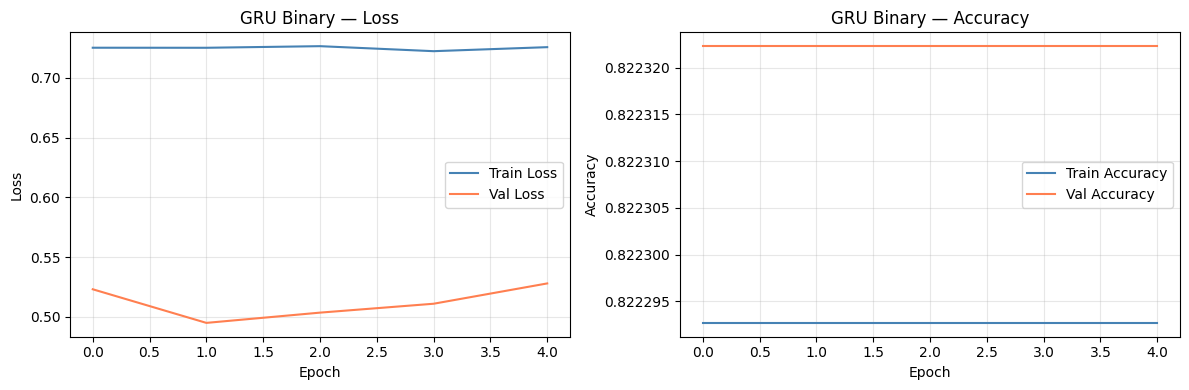


  GRU Binary — Evaluation Results
              precision    recall  f1-score   support

Not Relevant       0.82      1.00      0.90      1643
    Relevant       0.00      0.00      0.00       355

    accuracy                           0.82      1998
   macro avg       0.41      0.50      0.45      1998
weighted avg       0.68      0.82      0.74      1998



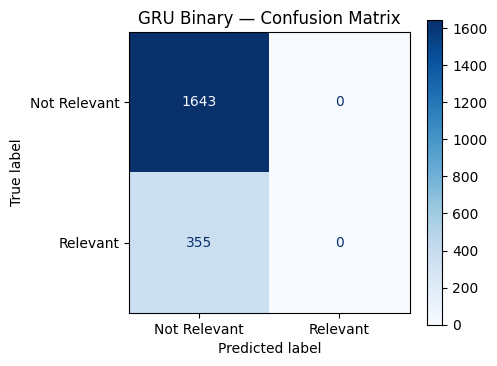

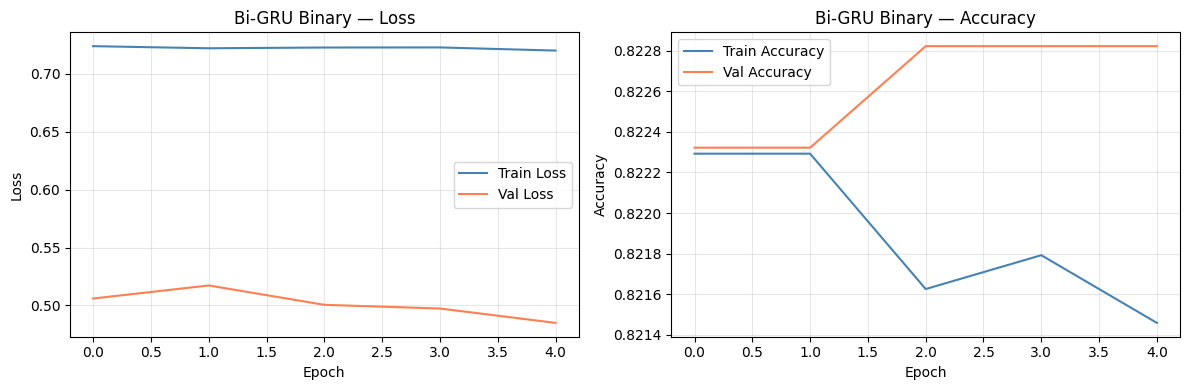


  Bi-GRU Binary — Evaluation Results
              precision    recall  f1-score   support

Not Relevant       0.82      1.00      0.90      1643
    Relevant       1.00      0.00      0.01       355

    accuracy                           0.82      1998
   macro avg       0.91      0.50      0.45      1998
weighted avg       0.85      0.82      0.74      1998



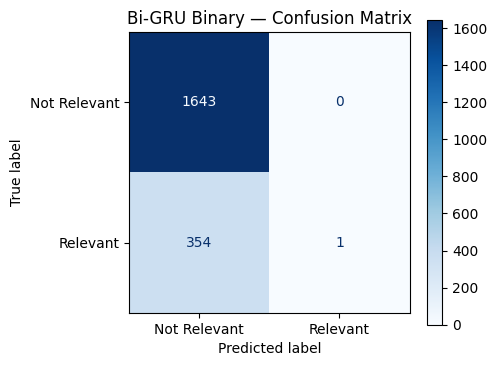

array([0, 0, 0, ..., 0, 0, 0])

In [32]:
# Evaluate both
plot_history(history_gru, "GRU Binary")
evaluate_model(model_gru_binary, X_test_dense, y_test, "GRU Binary")

plot_history(history_bigru, "Bi-GRU Binary")
evaluate_model(model_bigru_binary, X_test_dense, y_test, "Bi-GRU Binary")

---
## Part 2: Multi-class Classification — GRU

In [34]:
# ============================================================
# LOAD DATA — BBC News (Multi-class: 5 categories)
# ============================================================
bbc_df = get_data('bbc-news-data.csv', sep='\t')
print(f"Shape: {bbc_df.shape}")
print(f"\nCategory distribution:")
print(bbc_df['category'].value_counts())

# Clean text (title + content combined)
bbc_df['clean'] = (bbc_df['title'] + ' ' + bbc_df['content']).apply(clean)

# Encode labels
le = LabelEncoder()
bbc_df['target'] = le.fit_transform(bbc_df['category'])
class_names = list(le.classes_)
num_classes = len(class_names)
print(f"\nClasses: {dict(zip(class_names, range(num_classes)))}")

⬇️  Downloading from GitHub: bbc-news-data.csv...
✅ Downloaded (2225 rows)
Shape: (2225, 4)

Category distribution:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

Classes: {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}


In [48]:
# ============================================================
# TOKENIZE & PAD — Multi-class
# ============================================================
tokenizer_mc = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer_mc.fit_on_texts(bbc_df['clean'])

X_mc = pad_sequences(tokenizer_mc.texts_to_sequences(bbc_df['clean']),
                     maxlen=MAX_LEN, padding='post', truncating='post')
y_mc = bbc_df['target'].values

X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
    X_mc, y_mc, test_size=0.25, random_state=42, stratify=y_mc)
print(f"Train: {X_train_mc.shape} | Test: {X_test_mc.shape}")

train_ds = make_dataset(X_train_mc, y_train_mc)
test_ds = make_dataset(X_test_mc, y_test_mc, shuffle=False)
print(f"✅ Multi-class pipelines ready")

Train: (1668, 500) | Test: (557, 500)
✅ Multi-class pipelines ready


Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.2116 - loss: 1.6081 - val_accuracy: 0.2531 - val_loss: 1.5950
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.2996 - loss: 1.5879 - val_accuracy: 0.3519 - val_loss: 1.5644
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4797 - loss: 1.5292 - val_accuracy: 0.5386 - val_loss: 1.3971
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5340 - loss: 1.2503 - val_accuracy: 0.5996 - val_loss: 1.1157
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7324 - loss: 0.9487 - val_accuracy: 0.7145 - val_loss: 0.7886
Restoring model weights from the end of the best epoch: 5.

⏱️ Training time: 6.6 seconds


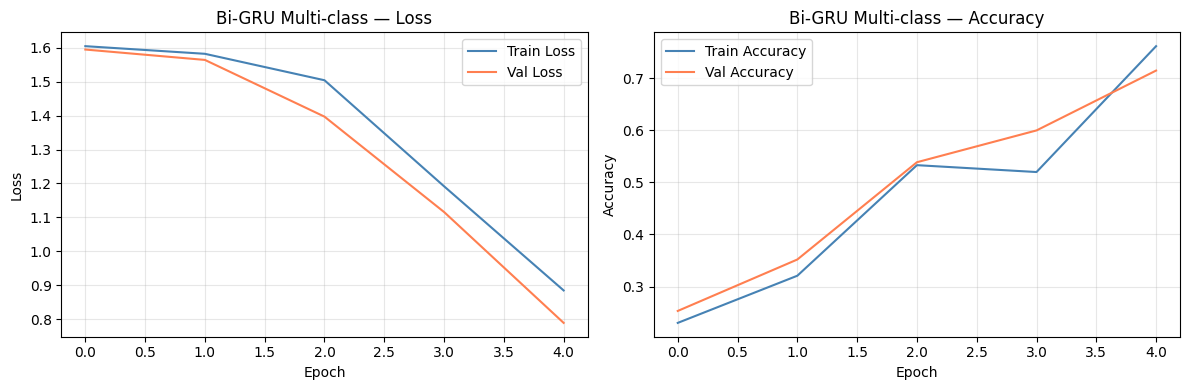


  Bi-GRU Multi-class
               precision    recall  f1-score   support

     business       0.57      0.94      0.71       128
entertainment       0.89      0.85      0.87        97
     politics       0.86      0.70      0.77       104
        sport       0.71      0.94      0.81       128
         tech       1.00      0.03      0.06       100

     accuracy                           0.71       557
    macro avg       0.81      0.69      0.64       557
 weighted avg       0.79      0.71      0.66       557



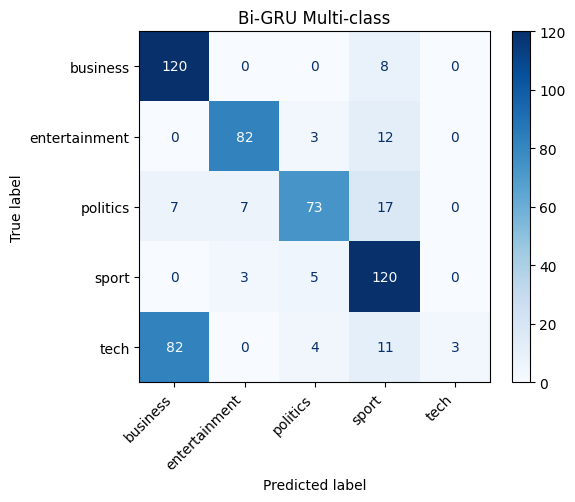

In [50]:
import time

# ============================================================
# MODEL 2: GRU — Multi-class Classification
# ============================================================
model_gru_mc = keras.Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64), # Fixed: Use VOCAB_SIZE
    layers.Bidirectional(layers.GRU(64)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')                     # Fixed: Use num_classes (5 categories)
], name="BiGRU_MultiClass")

model_gru_mc.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

es_mc = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
train_start = time.time()
history_mc = model_gru_mc.fit(
    train_ds, # Fixed: Pass the tf.data.Dataset directly
    epochs=5,
    callbacks=[es_mc],
    verbose=1,
    validation_data=test_ds # Fixed: Use the correctly named test_ds
) # Removed batch_size as it's handled by the dataset
train_time = time.time() - train_start
print(f"\n⏱️ Training time: {train_time:.1f} seconds")

plot_history(history_mc, "Bi-GRU Multi-class")
evaluate_multiclass(model_gru_mc, X_test_mc, y_test_mc, class_names, "Bi-GRU Multi-class") # Fixed: Use NumPy arrays for evaluation

---
## Part 3: Multi-label Classification — GRU

In [51]:
# ============================================================
# LOAD DATA — Toxic Comments (Multi-label: 6 labels)
# ============================================================
toxic_df = get_data('toxic_comments_1k.csv')

# Keep rows with actual text
toxic_df = toxic_df[toxic_df['comment_text'].notna()].copy()
print(f"Shape (with text): {toxic_df.shape}")

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for col in label_cols:
    toxic_df[col] = toxic_df[col].fillna(0).astype(int)

print(f"\nLabel distribution:")
for col in label_cols:
    print(f"  {col}: {toxic_df[col].sum()} positive ({toxic_df[col].mean()*100:.1f}%)")
print(f"Avg labels per comment: {toxic_df[label_cols].sum(axis=1).mean():.2f}")

# Clean text
toxic_df['clean'] = toxic_df['comment_text'].apply(clean)

⬇️  Downloading from GitHub: toxic_comments_1k.csv...
✅ Downloaded (9999 rows)
Shape (with text): (9999, 8)

Label distribution:
  toxic: 971 positive (9.7%)
  severe_toxic: 101 positive (1.0%)
  obscene: 527 positive (5.3%)
  threat: 33 positive (0.3%)
  insult: 494 positive (4.9%)
  identity_hate: 84 positive (0.8%)
Avg labels per comment: 0.22


In [52]:
# ============================================================
# TOKENIZE & PAD — Multi-label
# ============================================================
tokenizer_ml = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer_ml.fit_on_texts(toxic_df['clean'])

X_ml = pad_sequences(tokenizer_ml.texts_to_sequences(toxic_df['clean']),
                     maxlen=MAX_LEN, padding='post', truncating='post')
y_ml = toxic_df[label_cols].values.astype(np.float32)
num_labels = len(label_cols)

X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_ml, y_ml, test_size=0.25, random_state=42)
print(f"Train: {X_train_ml.shape} | Labels: {y_train_ml.shape}")

train_ml_ds = make_dataset(X_train_ml, y_train_ml)
test_ml_ds = make_dataset(X_test_ml, y_test_ml, shuffle=False)
print(f"✅ Multi-label pipelines ready")

Train: (7499, 500) | Labels: (7499, 6)
✅ Multi-label pipelines ready


Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - binary_accuracy: 0.8524 - loss: 0.3933 - val_binary_accuracy: 0.9652 - val_loss: 0.1295
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - binary_accuracy: 0.9628 - loss: 0.1328 - val_binary_accuracy: 0.9711 - val_loss: 0.0811
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - binary_accuracy: 0.9726 - loss: 0.0812 - val_binary_accuracy: 0.9771 - val_loss: 0.0677
Epoch 4/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - binary_accuracy: 0.9791 - loss: 0.0592 - val_binary_accuracy: 0.9796 - val_loss: 0.0611
Epoch 5/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - binary_accuracy: 0.9822 - loss: 0.0497 - val_binary_accuracy: 0.9785 - val_loss: 0.0610
Restoring model weights from the end of the best epoch: 5.

⏱️ Training time: 18.4 seconds


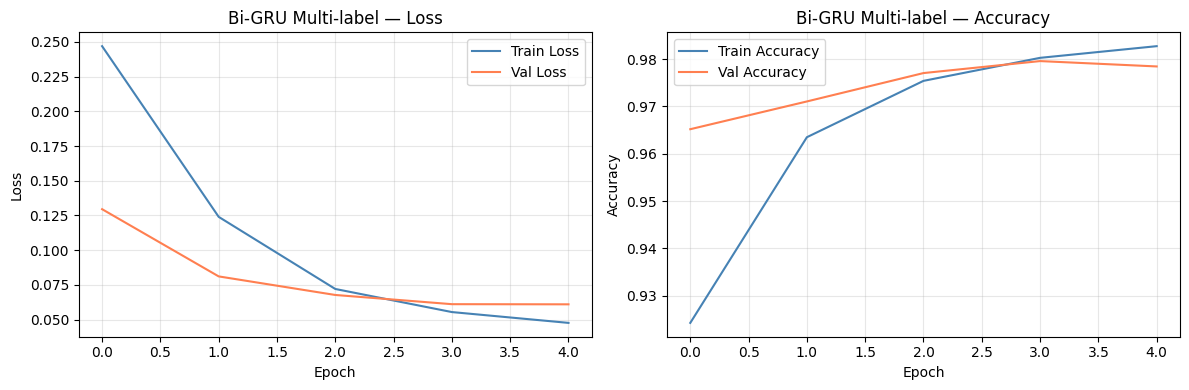


  Bi-GRU Multi-label — Multi-Label
               precision    recall  f1-score   support

        toxic       0.76      0.64      0.70       235
 severe_toxic       0.60      0.11      0.18        28
      obscene       0.79      0.66      0.72       121
       threat       0.00      0.00      0.00         8
       insult       0.68      0.57      0.62       114
identity_hate       0.00      0.00      0.00        16

    micro avg       0.75      0.57      0.65       522
    macro avg       0.47      0.33      0.37       522
 weighted avg       0.71      0.57      0.63       522
  samples avg       0.05      0.05      0.05       522

Per-label accuracy:
  toxic: 0.948
  severe_toxic: 0.989
  obscene: 0.975
  threat: 0.997
  insult: 0.968
  identity_hate: 0.994


In [54]:
import time

# ============================================================
# MODEL 3: GRU — Multi-label Classification
# ============================================================
model_gru_ml = keras.Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64),
    layers.Bidirectional(layers.GRU(64)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_labels, activation='sigmoid')                     # SIGMOID for multi-label, num_labels from earlier cell
], name="BiGRU_MultiLabel")

model_gru_ml.compile(
    loss='binary_crossentropy',                                # BCE for multi-label
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['binary_accuracy']
)

es_ml = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
train_start = time.time()
history_ml = model_gru_ml.fit(
    train_ml_ds,  # Use the tf.data.Dataset for training
    epochs=5,
    validation_data=test_ml_ds,  # Use the tf.data.Dataset for validation
    callbacks=[es_ml],
    verbose=1
) # Removed batch_size as it's handled by the dataset
train_time = time.time() - train_start
print(f"\n⏱️ Training time: {train_time:.1f} seconds")

plot_history(history_ml, "Bi-GRU Multi-label")
evaluate_multilabel(model_gru_ml, X_test_ml, y_test_ml, label_cols, title="Bi-GRU Multi-label") # Use X_test_ml and y_test_ml NumPy arrays, and label_cols

In [56]:
model_gru_ml.summary()

Model: "BiGRU_MultiLabel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 500, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,122,740 (4.28 MB)

 Trainable params: 374,246 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 748,494 (2.86 MB)

---
## Summary: GRU vs LSTM Decision Guide

| Factor | Choose GRU | Choose LSTM |
|---|---|---|
| **Dataset size** | Small-medium (<50K) | Large (100K+) |
| **Sequence length** | Short-medium text | Long documents |
| **Training time** | Need fast iteration | Time is not an issue |
| **Parameter budget** | Limited GPU memory | GPU memory available |
| **Default choice** | ✅ Try first | Upgrade if GRU underfits |

### The Complete Decision Tree
```
Start with GRU (fastest, fewest params)
  ├── Accuracy good enough? → Ship it ✅
  └── Need more accuracy?
        ├── Try Bi-GRU (adds backward pass)
        ├── Try LSTM (more gates, more capacity)
        ├── Try Bi-LSTM (maximum sequence model power)
        └── Still not enough? → Consider Transformers (Notebook: DistilBERT)
```